# By Adam Ishay

## Imports

In this notebook, MNIST hand-written digits will be trained on to create a model for classification. 

In [1]:
import numpy as np
import os
import time
import pdb


import matplotlib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.externals import joblib
from skimage.transform import rotate
from skimage.transform import swirl
np.random.seed(42)

%matplotlib inline

## Preprocessing Data

In [2]:
mnist=fetch_mldata("MNIST original")
mnist
X, y = mnist["data"], mnist["target"]
X_train_copy=X[:60000].copy()
y_train_copy=y[:60000].copy()
X_test_copy=X[60000:].copy()
y_test_copy=y[60000:].copy()

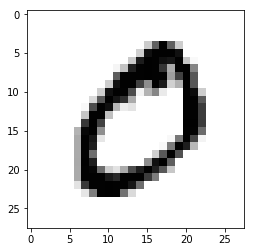

In [3]:
plt.imshow(X_train_copy[0].reshape((28,28)),cmap=matplotlib.cm.binary)

Features with very high variance and very low variance will be removed, as it will decrease training time while retaining most useful information. Features with a variance close to zero do not have much information and are less useful, while the features that have a very large variance can be viewed as too volatile for our purposes. These features may have useful information, but for us, are not worth the extra training time. 

I start with removing all the features with a variance over 1100. The value 1100 was found by just trying out different values and seeing the result on the accuracy. This step reduces the number of features to 404, down from 784. 




In [4]:
variance = np.var(X, axis = 0)>1100;
X = X[:, variance];
X.shape

(70000, 404)

The training and test splits are made, and the training data is shuffled. An additional X_train_pca and X_test_pca is created, this will be used in the next step. 

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

m=X_train.shape[0]

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]
X_train_pca,X_test_pca=X_train.copy(),X_test.copy()

The plan is to implement a support vector machine with the 'rbf' kernel, which is a non-linear kernel, and means radial basis function. Unlike the support vector machine from the SGDClassifier, this one is non-linear and will take a longer time to train. For this reason, it is important to reduce the number of features to as much as reasonably possible while preserving the information in the data. This is done using principal component analysis (PCA). This algorithm will reduce the features to a number, or to a percent of variance preserved, I choose. I played around with this and I got good accuracy with n=35. This means that 35 features will be left in the data, all the way down from 784. I started off getting relatively bad results until I used whiten=True. Whitening transforms the features to be uncorrelated with eachother.

Trying to run this SVM with many features results in a long training time, so this step is important. 

We will use the PCA method from sklearn. First I will make two functions to make the process simpler. The first one is for applying PCA to the data, and the second function is for applying PCA to the augmented data I will create later. Notice that the pca object is fitted on only the training data and then applied to both the training and test data. Also, the first function returns the PCA object to be used later for the augmented data. This is important because the all the data should be transformed the same way.

In [6]:
def PrincipalComponents(n):
    pca = PCA(n_components= n,whiten=True)
    X_train1 = pca.fit_transform(X_train_pca)
    X_test1 = pca.transform(X_test_pca)
    return X_train1, X_test1,pca

def PrincipalComponents_aug(X_aug,pca):
    
    X_aug=pca.transform(X_aug)
    return X_aug

In [7]:
n=35
X_train,X_test,pca=PrincipalComponents(n=n)
X_train.shape


(60000, 35)

Now that the feature size is reduced, we can start to think about training our model. To find a good set of hyperparameters, I used a gridsearch, however, this was done over several iterations of gridsearch, which each took up to ten minutes. Here is an example of a grid search I used to get me started. I also searched the parameter 'gamma', and the type of kernel, and found a value of .05 and 'rbf'  to be best, respectively. The value searched here, C, represents how much our model is willing to misclassify, where a high C would mean not very much. A high C can to overfitting. We used a 3-fold cross-validation for this part on 10,000 examples. 

After it is done searching, to find see what the best parameters were we check the 'best_params_' attribute in the gsc2 object. In this case it is 3. Searching more I found 2.8 was better.

In [8]:
gsc2 = GridSearchCV( estimator=SVC(), param_grid={ 'C': [1,  3,  5,7,10]}, cv=3, verbose=2,n_jobs=-1 )
gsc2.fit(X_train[:10000], y_train[:10000])
gsc2.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=-1)]: Done   8 out of  15 | elapsed:    8.3s remaining:    7.2s
[Parallel(n_jobs=-1)]: Done  15 out of  15 | elapsed:   11.2s finished


{'C': 3}

In this search, C=3 was the best performer. Now we can start training. 

## Model

### Run #1 (original 60,000 images)

In [9]:
tic=time.time()


svm=SVC(kernel='rbf', C=2.8,gamma=.05,random_state=42)

print('Training...')
svm.fit(X_train,y_train)
print('Training Complete')
toc=time.time()

print("time for training is " + str((toc-tic))+ " seconds" )

Training...
Training Complete
time for training is 71.35876679420471 seconds


In [10]:
#y_pred_train=svm.predict(X_train)
y_pred_test = svm.predict(X_test)

In [11]:
#print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

0.9855


Originally I wanted to shoot for 98.5% accuracy. After fitting on the training data, we get a little over 98.5%. So now let's try to shoot for >99%. This extra .5% doesn't seem like much, but it may require significant work to achieve since there is much less room to improve now. 


## Data Augmentation

Data augmentation will likely help our accuracy a bit, so we will see where that takes us. Here we will be translating all the images one pixel in each direction. Since there are 60,000 training images, there will be (60,000 X 4)=240,000 additional images. This means there will be 300,000 training images total. This is quite a lot and since SVMs (at least 'rbf') ones scale quadratically with number of examples, this is something we should consider. 

Here we define a function that will add these 240,000 training examples.

In [12]:
def add_data(X_train_copy,y_train_copy,X_train,y_train,pca):
    
    X_reshape=np.reshape(X_train_copy,(1680000,28)) # combine arrays
    
    fig = plt.figure(figsize=(10, 25))
    plt.subplot(151);plt.imshow(X_reshape[:112,:],cmap=matplotlib.cm.binary)

    
    #shift up
    X_shiftU=np.delete(X_reshape,0,0)
    X_shiftU=np.vstack((X_shiftU,np.zeros((1,28))))
    plt.subplot(152);plt.imshow(X_shiftU[:112,:],cmap=matplotlib.cm.binary)
    X_shiftU=np.reshape(X_shiftU,(60000,784))
    
    #shift down
    X_shiftD=np.delete(X_reshape,1679999,0)
    X_shiftD=np.vstack((np.zeros((1,28)),X_shiftD))
    plt.subplot(153);plt.imshow(X_shiftD[:112,:],cmap=matplotlib.cm.binary)
    X_shiftD=np.reshape(X_shiftD,(60000,784))
    
    #shift right
    X_shiftR=np.delete(X_reshape,27,1)
    X_shiftR=np.hstack((np.zeros((1680000,1)),X_shiftR))
    plt.subplot(154);plt.imshow(X_shiftR[:112,:],cmap=matplotlib.cm.binary)
    X_shiftR=np.reshape(X_shiftR,(60000,784))
    #shift left
    X_shiftL=np.delete(X_reshape,0,1)
    X_shiftL=np.hstack((X_shiftL,np.zeros((1680000,1))))
    plt.subplot(155);plt.imshow(X_shiftL[:112,:],cmap=matplotlib.cm.binary)
    X_shiftL=np.reshape(X_shiftL,(60000,784))
    
    

    #concatenate
    X_total=np.vstack((X_shiftU,X_shiftD,X_shiftR,X_shiftL));
    X_total=X_total[:,variance]
    
    X_total=PrincipalComponents_aug(X_total,pca)
    X_total=np.vstack((X_train,X_total))
    y_total=np.hstack((y_train,y_train_copy,y_train_copy,y_train_copy,y_train_copy))
    
    shuffle_index = np.random.permutation(X_total.shape[0])
    X_total=X_total[shuffle_index]
    y_total=y_total[shuffle_index]
    return X_total,y_total

This function takes in the original training data and makes 4 copies. For each copy, the 60,000 images are stacked on top of eachother to make a (1680000,28) array. Then a row of pixels are deleted from one side of this array to get the corresponding translation. So for instance, to move all the images one pixel to the right, the rightmost column of the stacked array is deleted and another column of zeros is added on the left side. Then they are reshaped back into four 60,000 X 784 arrays.After this, they are concatenated and then preprocessed in the same way (removing high variance >1100, PCA object used from before, and shuffling). A 300,000 X 35 array is returned in X_total and their corresponding labels are in y_total (300,000 X 1).

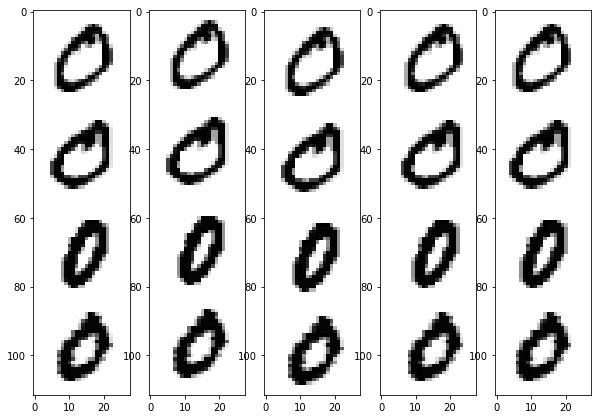

In [13]:
X_total,y_total=add_data(X_train_copy,y_train_copy,X_train,y_train,pca)


Plotted above is a part of the stacked array of pictures with the leftmost image being the untouched array, with the next four being shifted up,down,right, and left, respectively. After this step, they are reshaped back into four 60,000 X 784 arrays which go through preprocessing. The total training data shape is shown below.

In [14]:
X_total.shape,y_total.shape

((300000, 35), (300000,))

### Run #2 (original 60,000 images + additional 240,000 shifted images)

Now we can train this. This took me roughly an hour to train and predict ( CTRL + /, to block uncomment). If you have the models downloaded in the same folder as this notebook, then they will just be loaded. Predicting the 60,000 training examples to get a training accuracy takes some time, so I commented it out. Training accuracy was .99+.

In [15]:
# Training
# SVM_trans_aug=SVC(kernel='rbf', C=2.8,gamma=.05,random_state=42)
# SVM_trans_aug.fit(X_total,y_total)
# print('Done Training')
# y_pred_train = SVM_trans_aug.predict(X_total)
# y_pred_test = SVM_trans_aug.predict(X_test)
# print(accuracy_score(y_total,y_pred_train), accuracy_score(y_test, y_pred_test))

# Loading model instead

C_28_trans_aug=joblib.load('C_28_trans_aug.pkl')
y_pred_test = C_28_trans_aug.predict(X_test)
print(accuracy_score(y_test,y_pred_test))
#y_pred_total = SVM_trans_aug.predict(X_total)
#print(accuracy_score(y_total,y_pred_total))

0.9894


Adding these examples increased our accuracy to 98.94%, that's up about .40%, which brings us pretty close to my 99% goal. To try to get there I added an additional 60,000 augmented training examples, but this time rotated. I played around with the rotation angle and found that 15 degrees rotation gave good results. We will need a function to do this for us. 

In [18]:
def add_rotated(angle,X_train_copy,y_train_copy,X_train,y_train,X_total,y_total,pca):

    X_new=X_train_copy
    m_new=60000
    
    random1=np.array([np.random.choice([-1,1],size=m_new)]);random1=random1.T
    X_rot=np.array(np.zeros((m_new,28,28)))
    X_rot[0]=rotate(X_new[0].reshape(28,28),random1[0]*angle,preserve_range=True)
    
    plt.subplot(221);plt.imshow(X_train_copy[0].reshape((28,28)),cmap=matplotlib.cm.binary)
    plt.subplot(222);plt.imshow(X_rot[0],cmap=matplotlib.cm.binary)

    
    for i in range(1,m_new):
        X_rot[i]=rotate(X_new[i].reshape(28,28),random1[i]*angle,preserve_range=True)
    
    plt.subplot(223);plt.imshow(X_train_copy[40000].reshape((28,28)),cmap=matplotlib.cm.binary)
    plt.subplot(224);plt.imshow(X_rot[40000],cmap=matplotlib.cm.binary)
    
    X_rot=np.reshape(X_rot,(m_new,784));
    X_rot=X_rot[:,variance]
    X_rot=PrincipalComponents_aug(X_rot,pca)
    X_total=np.vstack((X_total,X_rot))
    y_total=np.hstack((y_total,y_train_copy))
    
    shuffle_index = np.random.permutation(X_total.shape[0])
    
    X_total=X_total[shuffle_index]
    y_total=y_total[shuffle_index]
    

    return X_total,y_total




This function first rotates randomly (clockwise or counter-clockwise) each reshaped(28,28) training example by the angle specified. Then it is shaped back in to a 784 dimensional array, goes through the standard preprocessing and is shuffled with the rest of the examples. There should now be 360,000 training examples. The preserve_range parameter should be set to True to not change the feature scale.

Caution: if you run the below block more than once, it will add an additional 60,000 examples to the training data each time.

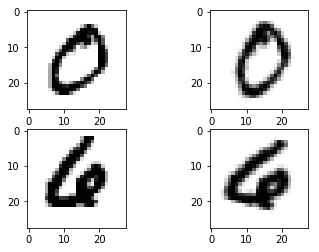

In [19]:
X_total,y_total=add_rotated(15,X_train_copy,y_train_copy,X_train,y_train,X_total,y_total,pca)

The two numbers above are rotated 15 a random direction by 15 degrees.

In [18]:
X_total.shape

(360000, 35)

### Run #3 (original 60k + additional 240k shifted images + additional 60k rotated images)

Training for this will take even longer, roughly an hour and a half for training and prediction.

In [19]:
# Training
# SVM_trans__rot_aug=SVC(kernel='rbf', C=2.8,gamma=.05,random_state=42)
# SVM_trans__rot_aug.fit(X_total,y_total)
# print('Done Training')
# y_pred_train = SVM_trans__rot_aug.predict(X_total)
# y_pred_test = SVM_trans__rot_aug.predict(X_test)
# print(accuracy_score(y_total,y_pred_train), accuracy_score(y_test, y_pred_test))

# Loading model instead

SVM_C_28_trans_rot_15_aug=joblib.load('SVM_C_28_trans_rot_15_aug.pkl')
y_pred_test = SVM_C_28_trans_rot_15_aug.predict(X_test)
print(accuracy_score(y_test,y_pred_test))
#y_pred_total = SVM_trans_aug.predict(X_total)
#print(accuracy_score(y_total,y_pred_total))





0.9907


# Results

99.07% Accuracy! That means out of the 10,000 test set, only 93 were predicted wrong. I am satisfied now, and won't go any further, even though I think I could get another .10%, although at the risk of overfitting. I think that instead of using just random rotation, using 60k images in each direction (120k more) may add a significant amount of accuracy (I ended up trying this, and error increased .01%). 

Adding data augmentation to our model increased accuracy significantly and additional rotation squeezed out a little bit more accuracy. But using just the original 60,000 images, training time was about a minute, where adding 4 X 60,000 additional training data increased training time to over an hour. The feature size reduction using PCA was crucial to have a reasonable training time. 

In [20]:
conf_mx = confusion_matrix(y_test, y_pred_test)
conf_mx

array([[ 977,    0,    0,    0,    0,    0,    1,    1,    1,    0],
       [   0, 1132,    2,    0,    0,    0,    0,    0,    0,    1],
       [   0,    2, 1026,    2,    0,    0,    0,    2,    0,    0],
       [   0,    0,    0, 1006,    0,    3,    0,    0,    1,    0],
       [   0,    0,    0,    0,  970,    0,    4,    0,    0,    8],
       [   2,    0,    0,    8,    0,  879,    3,    0,    0,    0],
       [   3,    2,    2,    1,    1,    2,  945,    0,    2,    0],
       [   0,    4,    4,    0,    0,    0,    1, 1016,    1,    2],
       [   2,    0,    1,    1,    1,    1,    1,    1,  965,    1],
       [   1,    2,    0,    1,    5,    5,    0,    2,    2,  991]], dtype=int64)

In [21]:
# indexes predicted wrong
wrong_index=(y_pred_test-y_test!=0).nonzero();wrong_index=wrong_index[0]
wrong_index

array([ 139,  629,  634, 1231, 1328, 1465, 2118, 2178, 2190, 2320, 2550,
       2614, 3186, 3456, 3621, 4152, 4173, 4188, 4263, 4280, 4295, 4330,
       4388, 4390, 4570, 4749, 5000, 5118, 5200, 5264, 5323, 5376, 5462,
       5478, 5509, 5662, 5684, 5875, 6010, 6012, 6014, 6066, 6118, 6133,
       6221, 6223, 6267, 6302, 6352, 6360, 6645, 6818, 6956, 6958, 7115,
       7118, 7123, 7139, 7201, 7263, 7366, 7387, 7452, 7588, 7654, 7903,
       8066, 8102, 8138, 8160, 8294, 8307, 8484, 8830, 8840, 9075, 9106,
       9107, 9158, 9177, 9220, 9247, 9276, 9278, 9325, 9334, 9379, 9401,
       9409, 9444, 9491, 9662, 9959], dtype=int64)

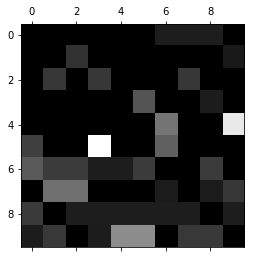

In [22]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

From this normalized confusion matrix, you can see that the most common errors are 5s get mistaken for 3s and 4s get mistaken by 9s.

In [23]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

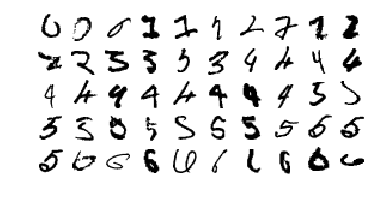

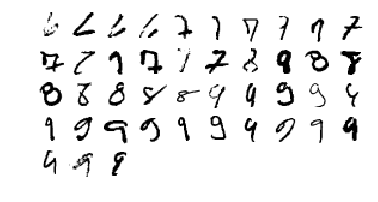

In [24]:
plot_digits(X_test_copy[wrong_index[:50]]);plt.figure();plot_digits(X_test_copy[wrong_index[50:]])

Plotted above are all the misclassified numbers, and it is not a surprise that most ofthem are misclassified. Most of them appear somewhat sloppily written. But I would correctly classify most of them so there should be room for higher accuracy with a more powerful algorithm such as a convolutional neural network.

You can see that two of the 9s look almost exactly the same, it is likely that they were written by the same person (MNIST used about 250 writers).


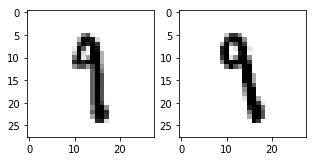

In [25]:
fig = plt.figure(figsize=(5, 25))
plt.subplot(121);plt.imshow(X_test_copy[wrong_index[80]].reshape((28,28)),cmap=matplotlib.cm.binary);
plt.subplot(122);plt.imshow(X_test_copy[wrong_index[84]].reshape((28,28)),cmap=matplotlib.cm.binary)

The results can be summarized in this table.

<table style="width:85%">
  <tr>
    <th>Run #</th>
    <th>Training Data</th>
    <th>Test Accuracy</th> 
  </tr>
  <tr>
    <td>1</td>
    <td>Original 60k images</td>  
    <td>98.55%</td>
  </tr>
  <tr>
    <td>2</td>
    <td>Original 60k images + 240k shifted</td> 
    <td>98.94%</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Original 60k images + 240k shifted + 60k rotated</td> 
    <td>99.07%</td>
  </tr>
</table>
